In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import psutil
import requests
import seaborn as sns

from utils import *
from datasets import *
from models import *
from transforms import *
from profiler import *

Available workers: 16


In [3]:
maxpeaks = 15
minpeaks = 1
maxscore = 12
minscore = 3.5
selection = f"peaks>{minpeaks} & peaks<{maxpeaks} & score>{minscore} & score<={maxscore}"

# Melanogaster and Suzukii main data

In [4]:
dmel1 = WingbeatDatasetProfiler(dsname="Melanogaster_RL/Z", custom_label=[0])
dsuz1 = WingbeatDatasetProfiler(dsname="Suzukii_RL/Y", custom_label=[1])
dmel2 = WingbeatDatasetProfiler(dsname="Melanogaster_RL/Y", custom_label=[0])
dsuz2 = WingbeatDatasetProfiler(dsname="Suzukii_RL/X", custom_label=[1])

Found 24763 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.
Found 25732 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.
Found 29002 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.
Found 19657 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.


In [92]:
temprs, humds = [],[]
for i in [dmel1, dmel2, dsuz1, dsuz2]:
    i.wbts.parse_filenames(temp_humd=True)
    tmp = i.wbts.df
    humds.append(tmp.humidity)
    temprs.append(tmp.temperature)
humds, temprs = pd.concat(humds), pd.concat(temprs)

print(f"Average humidity: {(humds[humds>50]-50).mean().round(0)}")
print(f"std: {(humds[humds>50]-50).std().round(0)}")
print(f"Average temperature: {temprs.mean().round(1)}")
print(f"std: {temprs.std().round(1)}")


Average humidity: 64.0
std: 5.0
Average temperature: 21.7
std: 0.6


# Plots of time signals and PSDs

100%|██████████| 20/20 [00:00<00:00, 24.97it/s]


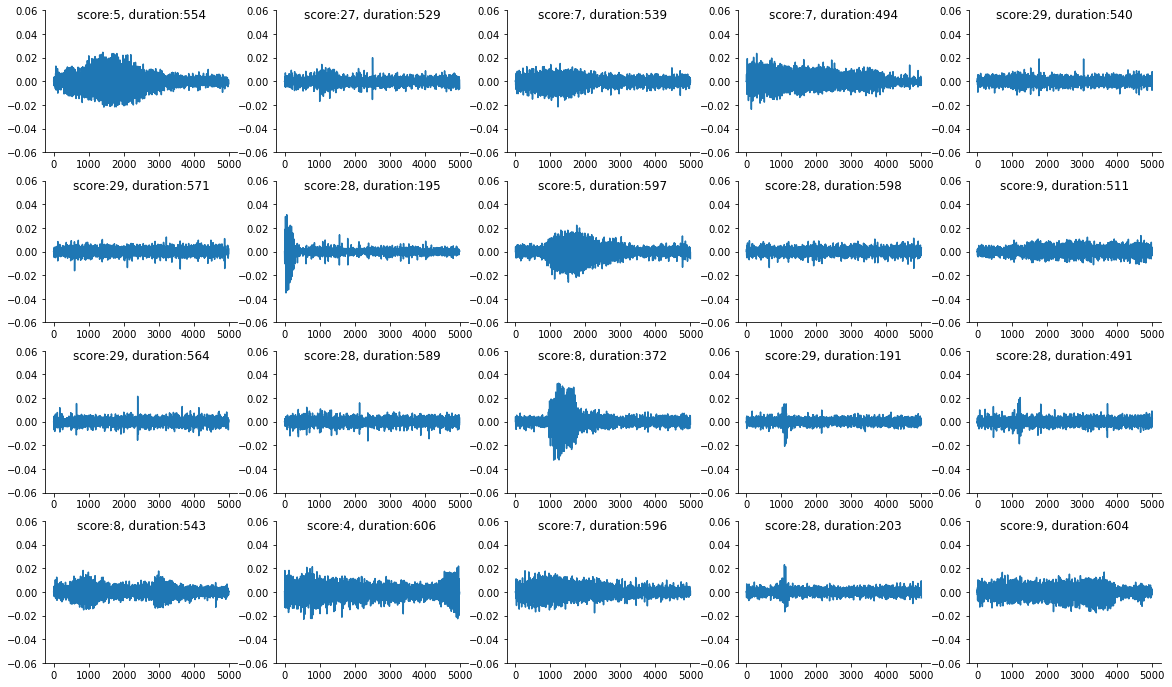

In [93]:
dmel1.plot_random_wbts(noaxis=False)

100%|██████████| 20/20 [00:00<00:00, 66.29it/s]


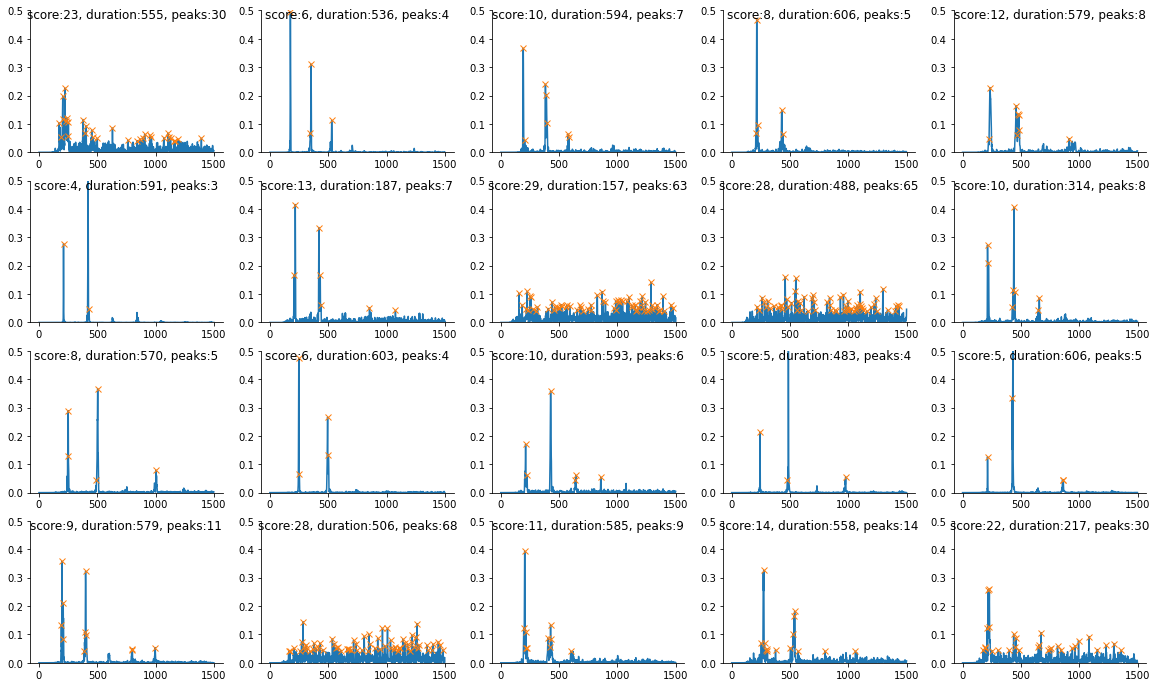

In [94]:
dmel1.plot_random_psds(noaxis=False)

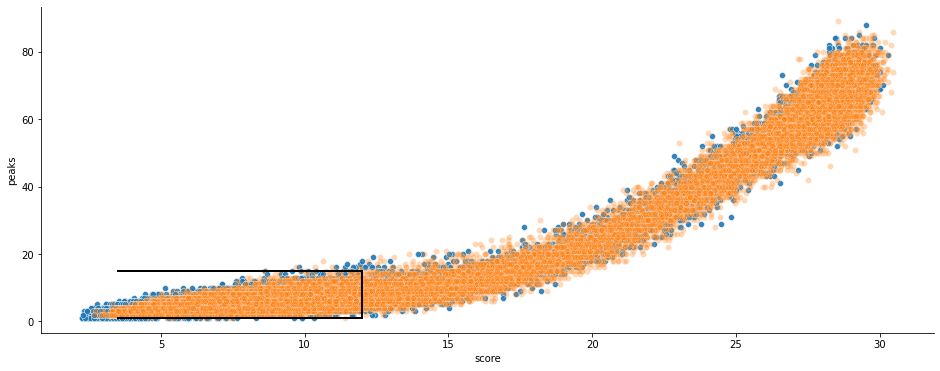

In [97]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=dsuz2.df, x="score", y="peaks", alpha=0.9);
sns.scatterplot(data=dmel2.df, x="score", y="peaks", alpha=0.3);
plt.plot([minscore, maxscore], [maxpeaks, maxpeaks], linewidth=2, c='black');
plt.plot([maxscore, maxscore], [minpeaks, maxpeaks], linewidth=2, c='black');
plt.plot([maxscore, maxscore], [minpeaks, maxpeaks], linewidth=2, c='black');
plt.plot([minscore, maxscore], [minpeaks, minpeaks], linewidth=2, c='black');

In [99]:
# plt.ylim(0,450)
# np_hist(dsuz1.df, 'score')

In [100]:
# plt.ylim(0,450)
# np_hist(dmel1.df, 'score');

In [101]:
# plt.ylim(0,3700)
# np_hist(dsuz1.df, 'peaks')

In [102]:
# plt.ylim(0,3700)
# np_hist(dmel1.df, 'peaks')

##### duration

In [103]:
# np_hist(dmel1.df, 'duration', res=2.5)

In [104]:
maxpeaks = 15
minpeaks = 1
maxscore = 12
minscore = 3.5
selection = f"peaks>{minpeaks} & peaks<{maxpeaks} & score>{minscore} & score<={maxscore}"

In [105]:
dfmel1 = dmel1.df.query(selection)
dfmel1.y = 0
dfmel2 = dmel2.df.query(selection)
dfmel2.y = 0

dfsuz1 = dsuz1.df.query(selection)
dfsuz1.y = 1
dfsuz2 = dsuz2.df.query(selection)
dfsuz2.y = 1

/home/kalfasyan/anaconda3/envs/wbai/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/kalfasyan/anaconda3/envs/wbai/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/kalfasyan/anaconda3/envs/wbai/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

### Clean examples

In [106]:
# dmel1.plot_random_psds(df=dfmel1, noaxis=False)

In [107]:
torch.backends.cudnn.benchmark = True
batch_size = 64

In [109]:
train_df = pd.concat([dfmel1, dfsuz1])
test_df = pd.concat([dfmel2, dfsuz2])

print(train_df.y.value_counts())
print(test_df.y.value_counts())

1    16857
0    12992
Name: y, dtype: int64
1    13560
0    12115
Name: y, dtype: int64


# Saving

In [18]:
train_df.to_parquet("../data_created/suzmel_train.parquet")
test_df.to_parquet("../data_created/suzmel_test.parquet")

In [11]:
# X, y = train_df.iloc[:, 0], train_df.iloc[:, 1]
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)

# dfs_train = DataFrameset(pd.concat([X_train, y_train], axis=1), transform=transforms.Compose(transforms_list_train))
# dfs_valid = DataFrameset(pd.concat([X_valid, y_valid], axis=1), transform=transforms.Compose(transforms_list_test))

# train_dataloader = DataLoader(dfs_train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
# valid_dataloader = DataLoader(dfs_valid, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

## MeBioS Suzukii and Melanogaster data

In [13]:
ds1 = WingbeatDatasetProfiler(dsname="Suzukii_RL/R", custom_label=[1])
ds2 = WingbeatDatasetProfiler(dsname="Suzukii_RL/L", custom_label=[1])
ds3 = WingbeatDatasetProfiler(dsname="Melanogaster_RL/X", custom_label=[0])
ds4 = WingbeatDatasetProfiler(dsname="Melanogaster_RL/W", custom_label=[0])

Found 14348 in dataset: Suzukii_RL/R, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.
Found 21940 in dataset: Suzukii_RL/L, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.
Found 2086 in dataset: Melanogaster_RL/X, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.
Found 1882 in dataset: Melanogaster_RL/W, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.


In [91]:
temprs, humds = [],[]
for i in [ds1, ds2, ds3, ds4]:
    i.wbts.parse_filenames(temp_humd=True)
    tmp = i.wbts.df
    humds.append(tmp.humidity)
    temprs.append(tmp.temperature)
humds, temprs = pd.concat(humds), pd.concat(temprs)

print(f"Average humidity: {(humds[humds>50]-50).mean().round(0)}")
print(f"std: {(humds[humds>50]-50).std().round(0)}")
print(f"Average temperature: {temprs.mean().round(1)}")
print(f"std: {temprs.std().round(1)}")


Average humidity: 55.0
std: 9.0
Average temperature: 23.3
std: 1.1


In [90]:
extra_df = pd.concat([ds1.df,ds2.df,ds3.df,ds4.df])
extra_df.y.value_counts()

1    36288
0     3968
Name: y, dtype: int64

In [113]:
extra_df = extra_df.query(selection)
extra_df.y.value_counts()

1    21572
0     1172
Name: y, dtype: int64

In [120]:
test_df.shape[0]

25675

In [115]:
extra_df.shape

(22744, 13)

In [17]:
extra_df.to_parquet("../data_created/suzmel_extra.parquet")

In [110]:
selection

'peaks>1 & peaks<15 & score>3.5 & score<=12'

In [114]:
extra_df.shape

(22744, 13)